In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from editdistance import eval as edit_distance

from simplipy import SimpliPyEngine

from tqdm import tqdm

from flash_ansr import get_path
from flash_ansr.eval.utils import bootstrapped_metric_ci
from flash_ansr.eval.token_prediction import f1_score, precision, recall

In [2]:
# This is where the results are stored
PATH_TO_EVALUATION_DATA = get_path('results', 'evaluation')
os.path.exists(PATH_TO_EVALUATION_DATA)

True

In [3]:
engine = SimpliPyEngine.load('dev_7-3', install=True)

In [4]:
# We will compare multiple series of experiments here, each model with different amounts of test time compute.
results = {
    'PySR': {'scaling_parameter': 'niterations'},
    'v21.0-8M': {'scaling_parameter': 'choices'},
    'v21.0-26M': {'scaling_parameter': 'choices'},
    'v21.0-60M': {'scaling_parameter': 'choices'},
    # 'v21.0-160M': {'scaling_parameter': 'choices'},
    # 'v21.0-370M': {'scaling_parameter': 'choices'},
}

In [5]:
for model in results.keys():
    print(f"Processing model {model}")
    if not 'scaling_parameter' in results[model]:
        raise ValueError("Please specify the scaling parameter for the model.")
    scaling_parameter = results[model]['scaling_parameter']

    # In the directory, there are multiple directories named "evaluation_<scaling_parameter_name>_<scaling_parameter_value>.yaml",
    # each each containing files "<test_set_name>.pickle" with the evaluation results for a specific test set.
    evaluations_list = os.listdir(os.path.join(PATH_TO_EVALUATION_DATA, f'{model}_{scaling_parameter}'))

    evaluations_list = [d for d in evaluations_list if d.startswith(f'evaluation_{scaling_parameter}_')]
    scaling_values = [int(d.split('_')[-1].split('.')[0]) for d in evaluations_list]

    scaling_values_argsort = np.argsort(scaling_values)
    scaling_values = [scaling_values[i] for i in scaling_values_argsort]
    evaluations_list = [evaluations_list[i] for i in scaling_values_argsort]

    results[model]['scaling_values'] = scaling_values
    results[model]['evaluations_list'] = evaluations_list
    results[model]['results'] = {}

    print(f"Found {len(evaluations_list)} evaluations with scaling values: {scaling_values}")
    for d in evaluations_list:
        print(f" - {d}")

Processing model PySR
Found 5 evaluations with scaling values: [1, 16, 64, 256, 1024]
 - evaluation_niterations_1
 - evaluation_niterations_16
 - evaluation_niterations_64
 - evaluation_niterations_256
 - evaluation_niterations_1024
Processing model v21.0-8M
Found 15 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
 - evaluation_choices_1
 - evaluation_choices_2
 - evaluation_choices_4
 - evaluation_choices_8
 - evaluation_choices_16
 - evaluation_choices_32
 - evaluation_choices_64
 - evaluation_choices_128
 - evaluation_choices_256
 - evaluation_choices_512
 - evaluation_choices_1024
 - evaluation_choices_2048
 - evaluation_choices_4096
 - evaluation_choices_8192
 - evaluation_choices_16384
Processing model v21.0-26M
Found 15 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
 - evaluation_choices_1
 - evaluation_choices_2
 - evaluation_choices_4
 - evaluation_choices_8
 - eval

In [6]:
TEST_SETS_FILTER = ['pool_15_10', 'feynman']

In [7]:
# Load the evaluation results
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    for d in tqdm(results[model]['evaluations_list'], desc="Loading evaluation results"):
        for test_set in TEST_SETS_FILTER:
            path_to_pickle = os.path.join(PATH_TO_EVALUATION_DATA, f'{model}_{scaling_parameter}', d, f"{test_set}.pickle")
            if not os.path.exists(path_to_pickle):
                print(f"Warning: {path_to_pickle} does not exist. Skipping.")
                continue
            with open(path_to_pickle, 'rb') as f:
                try:
                    result = pickle.load(f)
                except Exception as e:
                    print(f"Error loading {path_to_pickle}: {e}")
                    continue
            niterations = int(d.split('_')[-1].split('.')[0])
            if test_set not in results[model]['results']:
                results[model]['results'][test_set] = {}
            results[model]['results'][test_set][niterations] = result

    print(results[model]['results'].keys())

Loading evaluation results: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


dict_keys(['pool_15_10', 'feynman'])


Loading evaluation results:   7%|▋         | 1/15 [00:00<00:03,  4.37it/s]

Loading evaluation results:  13%|█▎        | 2/15 [00:00<00:03,  4.24it/s]

Loading evaluation results:  20%|██        | 3/15 [00:00<00:02,  4.20it/s]

Loading evaluation results:  27%|██▋       | 4/15 [00:00<00:02,  3.88it/s]

Loading evaluation results:  33%|███▎      | 5/15 [00:01<00:02,  3.66it/s]

Loading evaluation results:  40%|████      | 6/15 [00:01<00:02,  3.69it/s]

Loading evaluation results:  47%|████▋     | 7/15 [00:01<00:02,  3.74it/s]

Loading evaluation results:  53%|█████▎    | 8/15 [00:02<00:01,  3.80it/s]

Loading evaluation results:  60%|██████    | 9/15 [00:02<00:01,  3.43it/s]

Loading evaluation results:  67%|██████▋   | 10/15 [00:02<00:01,  3.43it/s]

Loading evaluation results:  73%|███████▎  | 11/15 [00:02<00:01,  3.54it/s]

Loading evaluation results:  80%|████████  | 12/15 [00:03<00:00,  3.45it/s]

Loading evaluation results: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


dict_keys(['pool_15_10'])


Loading evaluation results: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


dict_keys(['pool_15_10', 'feynman'])


Loading evaluation results:   7%|▋         | 1/15 [00:00<00:03,  3.91it/s]

Loading evaluation results:  13%|█▎        | 2/15 [00:00<00:03,  3.95it/s]

Loading evaluation results:  20%|██        | 3/15 [00:00<00:03,  3.98it/s]

Loading evaluation results:  27%|██▋       | 4/15 [00:01<00:02,  3.93it/s]

Loading evaluation results:  33%|███▎      | 5/15 [00:01<00:02,  3.81it/s]

Loading evaluation results:  40%|████      | 6/15 [00:01<00:02,  3.82it/s]

Loading evaluation results:  47%|████▋     | 7/15 [00:01<00:02,  3.81it/s]

Loading evaluation results:  53%|█████▎    | 8/15 [00:02<00:01,  3.80it/s]

Loading evaluation results:  60%|██████    | 9/15 [00:02<00:01,  3.78it/s]

Loading evaluation results:  67%|██████▋   | 10/15 [00:02<00:01,  3.70it/s]

Loading evaluation results:  73%|███████▎  | 11/15 [00:02<00:01,  3.61it/s]

Loading evaluation results:  80%|████████  | 12/15 [00:03<00:00,  3.28it/s]

Loading evaluation results:  87%|████████▋ | 13/15 [00:03<00:00,  3.37it/s]

Loading evaluation results: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

dict_keys(['pool_15_10'])


In [8]:
DEFAULT_NEGATIVES = {
    'constants': [],
    'error': None,
    'skeleton': [],
    'fit_time': np.inf,
    'input_ids': [],
    'labels': [],
    'labels_decoded': [],
    'n_support': np.nan,
    'parsimony': np.nan,
    'predicted_expression': [],
    'predicted_expression_prefix': [],
    'predicted_skeleton_prefix': [],
    'predicted_constants': [],
    'predicted_score': -np.inf,
    'predicted_log_prob': -np.inf,
    'prediction_success': False,
    'skeleton': [],
    'skeleton_hash': [],
    'x': np.nan,
    'x_val': np.nan,
    'y': np.nan,
    'y_noisy': np.nan,
    'y_noisy_val': np.nan,
    'y_pred': np.nan,
    'y_pred_val': np.nan,
    'y_val': np.nan,

    'f1_score': 0.0,
    'expression_length': np.inf,
    'predicted_skeleton_prefix_length': np.inf,
    'fvu_fit': np.inf,
    'fvu_val': np.inf,
    'log10_fvu_fit': np.inf,
    'log10_fvu_val': np.inf,
    'only_approx_fvu_fit': np.inf,
    'only_approx_fvu_val': np.inf,
    'only_approx_log10_fvu_fit': np.inf,
    'only_approx_log10_fvu_val': np.inf,
    'numeric_recovery_fit': 0.0,
    'numeric_recovery_val': 0.0,
    'n_variables': np.nan,
    'n_constants': np.inf,
    'predicted_n_constants': np.inf,
    'n_constants_delta': np.inf,
    'symbolic_recovery': 0.0,
    'skeleton_length_ratio': np.inf,
    'edit_distance': np.inf,
    'unique_variables': np.nan,
    'predicted_unique_variables': 0,
    'f1_score_unique_variables': 0.0,
    'precision_unique_variables': 0.0,
    'recall_unique_variables': 0.0,
    'total_nestedness': np.nan,
    'predicted_total_nestedness': np.inf,
}

In [9]:
# TODO: REMOVE
# limit = 256

In [10]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = np.array([(DEFAULT_NEGATIVES[metric] if r is None else r) for r in results[model]['results'][test_set][niterations][metric]])
                except ValueError:
                    pass  # setting an array element with a sequence

In [11]:
results.keys()

dict_keys(['PySR', 'v21.0-8M', 'v21.0-26M', 'v21.0-60M'])

In [12]:
def safe_divide(a, b):
    if b == 0:
        if a == 0:
            return np.inf
        return 0
    if np.isnan(a) or np.isnan(b):
        return np.nan
    if not np.isfinite(a) or not np.isfinite(b):
        print(a, b)
    return a / b

def fvu(y_true, y_pred):
    if y_pred is None or y_true is None:
        return np.inf
    y_pred = y_pred.astype(np.float64)
    y_true = y_true.astype(np.float64)

    # Check if the ground truth is finite but the prediction is not
    if np.isfinite(y_true).all() and not np.isfinite(y_pred).all():
        return np.inf

    # Scale y_true and y_pred by the inverse of the mean squared error to avoid numerical issues
    ss_res = np.mean((y_true - y_pred) ** 2)
    if ss_res == 0:
        return 0
    scale = 1 / ss_res

    ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
    ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)

    return safe_divide(ss_res, ss_tot)

def log10_fvu(y_true, y_pred):
    fvu_value = fvu(y_true, y_pred)
    if fvu_value == 0:
        return -np.inf
    return np.log10(fvu_value)

def is_perfect_fit(y_true, y_pred):
    return fvu(y_true, y_pred) <= np.finfo(np.float32).eps

def total_nestedness(prefix_skeleton: list[str]) -> int:
    nestedness = 0
    current_depth = 0
    for i, token in enumerate(prefix_skeleton):
        if engine.operator_arity.get(token, 0) == 1:
            current_depth += 1
        else:
            nestedness += max(0, current_depth - 1)
            current_depth = 0

    return nestedness

for model in results.keys():
    for test_set in tqdm(results[model]['results'].keys()):
        for scaling_value in results[model]['results'][test_set].keys():
            for split, saved_split_name in zip(['fit', 'val'], ['', '_val']):
                r = results[model]['results'][test_set][scaling_value]
                r[f'fvu_{split}'] = np.array([fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'log10_fvu_{split}'] = np.array([log10_fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'numeric_recovery_{split}'] = np.array([is_perfect_fit(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])

                r[f'only_approx_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'fvu_{split}'])
                r[f'only_approx_log10_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'log10_fvu_{split}'])

            r['f1_score'] = np.array([
                f1_score(np.array([predicted_skeleton_prefix]), np.array([skeleton])) if predicted_skeleton_prefix is not None else None  # Will be filled with default negatives in the cell below
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton'])])

            r['skeleton_length'] = np.array([
                len(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton']])
            
            r['predicted_skeleton_prefix_length'] = np.array([
                len(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_variables'] = np.array([
                len(set(token for token in skeleton if token.startswith('x'))) if skeleton is not None else None
                for skeleton in r['skeleton']])
            
            r['n_constants'] = np.array([
                skeleton.count('<constant>') if skeleton is not None else None
                for skeleton in r['skeleton']])
            
            r['predicted_n_constants'] = np.array([
                predicted_skeleton_prefix.count('<constant>') if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_constants_delta'] = np.array([
                predicted_n_constants - true_n_constants if predicted_n_constants is not None and true_n_constants is not None else None
                for predicted_n_constants, true_n_constants in zip(r['predicted_n_constants'], r['n_constants'])])

            r[f'symbolic_recovery'] = np.array([
                predicted_skeleton_prefix == skeleton if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton'])])

            r[f'skeleton_length_ratio'] = np.array([
                safe_divide(predicted_length, true_length) if predicted_length is not None and true_length is not None else None
                for predicted_length, true_length in zip(r['predicted_skeleton_prefix_length'], r['skeleton_length'])])

            r['edit_distance'] = np.array([
                edit_distance(predicted_skeleton_prefix, skeleton) if predicted_skeleton_prefix is not None and skeleton is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton'])])
            
            r['unique_variables'] = np.array([
                len(set(token for token in skeleton if token.startswith('x'))) if skeleton is not None else None
                for skeleton in r['skeleton']])

            r['predicted_unique_variables'] = np.array([
                len(set(token for token in predicted_skeleton_prefix if token.startswith('x'))) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['f1_score_unique_variables'] = np.array([
                f1_score(np.arange(predicted_unique_variables), np.arange(unique_variables)) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['precision_unique_variables'] = np.array([
                precision(np.arange(predicted_unique_variables), np.arange(unique_variables)) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['recall_unique_variables'] = np.array([
                recall(np.arange(predicted_unique_variables), np.arange(unique_variables)) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['total_nestedness'] = np.array([
                total_nestedness(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton']])

            r['predicted_total_nestedness'] = np.array([
                total_nestedness(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            

# print(results[list(results.keys())[0]]['results']['feynman'][1]['edit_distance'][:4])

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_28171/2702987276.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  y_pred = y_pred.astype(np.float64)
  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_28171/2702987276.py:23: RuntimeWarning: overflow encountered in square
  ss_res = np.mean((y_true - y_pred) ** 2)
100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


In [13]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = np.array([(DEFAULT_NEGATIVES[metric] if r is None else r) for r in results[model]['results'][test_set][niterations][metric]])
                except ValueError:
                    pass  # setting an array element with a sequence

In [14]:
# results[list(results.keys())[0]]['results']['feynman'][1]['fvu_val'].shape, results[list(results.keys())[0]]['results']['feynman'][1]['fit_time'].shape

In [15]:
def arrow_notation(objective: int = 1, lower: float | str = 0, upper: float | str = 1, lower_open: bool = False, upper_open: bool = False):
    lower_bracket = '(' if lower_open else '['
    upper_bracket = ')' if upper_open else ']'

    if lower == -np.inf:
        lower_bracket = '('
        lower = '-\\infty'
    if upper == np.inf:
        upper_bracket = ')'
        upper = '\\infty'

    try:
        float(lower)
        lower = f"{lower:.2g}"
    except:
        pass

    try:
        float(upper)
        upper = f"{upper:.2g}"
    except:
        pass

    if objective == 1:
        return f"\\uparrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    elif objective == -1:
        return f"\\downarrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    else:
        raise ValueError("Objective must be 1 (higher is better) or -1 (lower is better).")

In [16]:
def naninfmean(a):
    a = np.array(a)
    return np.nanmean(a[np.isfinite(a)])

/tmp/ipykernel_28171/4267528566.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(a[np.isfinite(a)])
/home/psaegert/Projects/flash-ansr/src/flash_ansr/eval/utils.py:24: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(bootstrapped_metrics)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


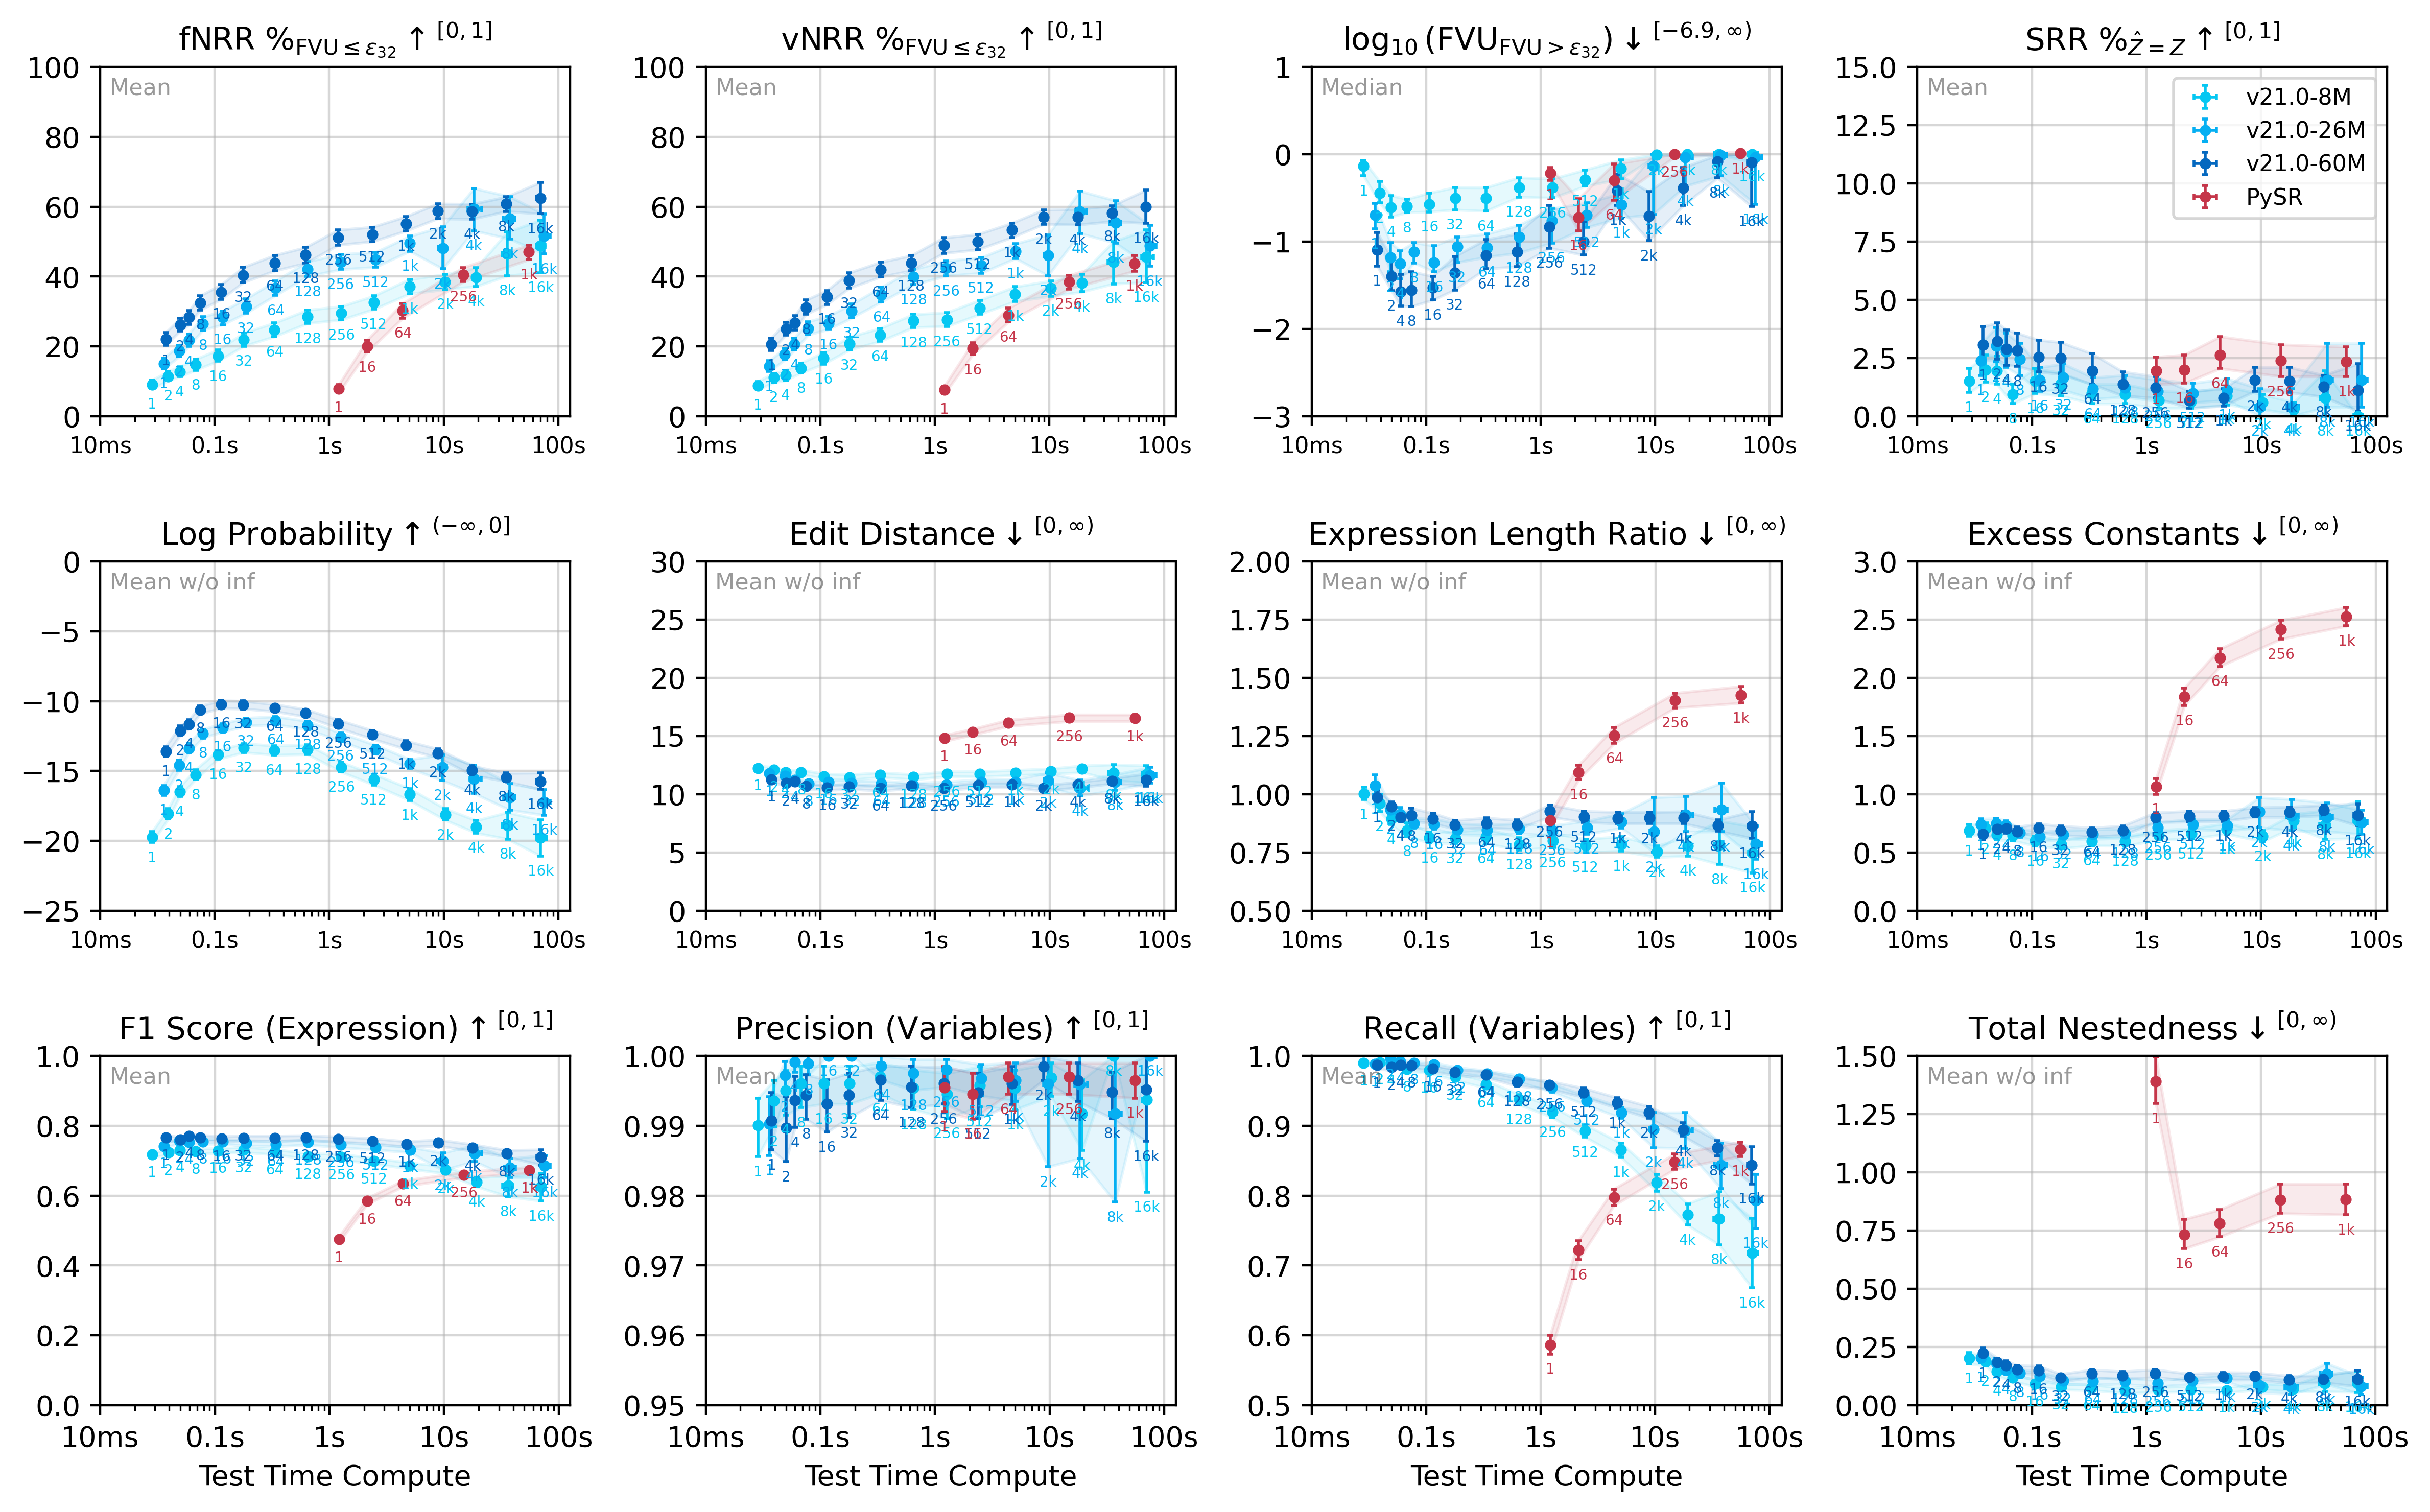

In [ ]:
metric_pairs = [
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'numeric_recovery_fit',
        f'fNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'only_approx_log10_fvu_val',
        f'$\\log_{{10}}(\mathrm{{FVU}}_{{\\mathrm{{FVU}} > \epsilon_{{32}}}}) {arrow_notation(objective=-1, lower=np.log10(np.finfo(np.float32).eps), upper=np.inf)}$',
        np.nanmedian,
        1,
        (-3, 1)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'symbolic_recovery',
        f'SRR $\\%_{{\hat{{Z}} = Z}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 15)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'predicted_log_prob',
        f'$\mathrm{{Log\\ Probability}} {arrow_notation(objective=1, lower=-np.inf, upper=0)}$',
        naninfmean,
        1,
        (-25, 0)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'edit_distance',
        f'$\mathrm{{Edit\\ Distance}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 30)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'skeleton_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 2)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'n_constants_delta',
        f'$\mathrm{{Excess\\ Constants}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 3)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'f1_score',
        f'$\mathrm{{F1\\ Score\\ (Expression)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.0, 1)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'precision_unique_variables',
        f'$\mathrm{{Precision\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.95, 1)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'recall_unique_variables',
        f'$\mathrm{{Recall\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.5, 1)
    )),
    (('fit_time', 'Test Time Compute', np.nanmedian), (
        'predicted_total_nestedness',
        f'$\mathrm{{Total\\ Nestedness}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 1.5)
    )),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v21.0-8M', 'choices', '#05C7F2'),
    ('v21.0-26M', 'choices', '#05AFF2'),
    ('v21.0-60M', 'choices', '#0468BF'),
    # ('v21.0-160M', 'choices', '#0339A6'),
    # ('v21.0-370M', 'choices', '#011640'),
    ('PySR', 'niterations', '#c53549'),
]

COLS = min(4, len(metric_pairs))
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

test_set = 'pool_15_10'

fig, axes = plt.subplots(ROWS, COLS, figsize=(3 * COLS, 2.5 * ROWS), dpi=200)


short_scaling_parameters = {
    1024: '1k',
    2048: '2k',
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k',
    65536: '64k',
}

for ax_id, (ax, ((x_metric, x_label, x_statistic), (y_metric, y_label, y_statistic, y_factor, ylim))) in enumerate(zip(axes.flatten(), metric_pairs)):
    ax: plt.Axes
    for model_name, scaling_param, color in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        if test_set not in results[model_name]['results']:
            continue

        for n in results[model_name]['results'][test_set].keys():
            x = results[model_name]['results'][test_set][n][x_metric]
            y = results[model_name]['results'][test_set][n][y_metric]

            # For the only_approx_log10_fvu_val, we want to ignore -inf values in the CI computation (These are cases where the model found the exact solution and should be masked out)
            if y_metric == 'only_approx_log10_fvu_val':
                # print(f"n={n}: Ignoring {np.sum(y == -np.inf)} / {len(results[model_name]['results'][test_set][n][y_metric])} (-inf) values for {y_metric}")
                y = y[y != -np.inf]

            x_ci = bootstrapped_metric_ci(x, x_statistic, n=1e3, interval=0.95)
            y_ci = bootstrapped_metric_ci(y, y_statistic, n=1e3, interval=0.95)

            x_median.append(x_ci[0])
            x_lower.append(x_ci[1])
            x_upper.append(x_ci[2])
            
            y_median.append(y_ci[0])
            y_lower.append(y_ci[1])
            y_upper.append(y_ci[2])
            
            # print(f"{y_metric:<30} {model_name:<15} {n:<5} nans: {np.sum(np.isnan(y)):<4} ({np.mean(np.isnan(y))*100:<5.1f}%) nonfinite: {np.sum(~np.isfinite(y)):<4} ({np.mean(~np.isfinite(y))*100:<5.1f}%)")

        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim)

        x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median) * y_factor, np.array(y_lower) * y_factor, np.array(y_upper) * y_factor

        # if model_name != 'PySR':
        #     model_name_label = '   ' + model_name
        # else:
        model_name_label = model_name

        ax.errorbar(x_median, y_median, yerr=[y_median - y_lower, y_upper - y_median], xerr=[x_median - x_lower, x_upper - x_median], fmt='.', label=model_name_label, capsize=1, color=color, elinewidth=1)
        ax.fill_between(x_median, y_lower, y_upper, color=color, alpha=0.1)

        for n, x_val, y_val, y_low in zip(results[model_name]['results'][test_set].keys(), x_median, y_median, y_lower):
            ax.annotate(short_scaling_parameters.get(n, str(n)), xy=(x_val, y_low), fontsize=5, color=color, textcoords="offset points", xytext=(0,-3), ha='center', va='top')

    # Annotate if mean or median is used
    y_statistic_name = {
        np.nanmean: f'Mean',
        np.nanmedian: f'Median',
        naninfmean: f'Mean w/o inf',
    }

    ax.annotate(y_statistic_name[y_statistic], xy=(0.02, 0.97), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='top', alpha=0.4)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel(x_label)
        x_ticks_fontsize=10
    else:
        x_ticks_fontsize=8

    ax.set_title(y_label, fontsize=11)
    ax.set_xscale('log')
    ax.set_xticks([0.01, 0.1, 1, 10, 100])
    ax.set_xticklabels(['10ms', '0.1s', '1s', '10s', '100s'], fontsize=x_ticks_fontsize)

    ax.grid(alpha=0.5)

axes.flatten()[3].legend(fontsize=8)

# flash = plt.imread(get_path('assets', 'flash.png'))
# ax_image = fig.add_axes([0.157, 0.75, 0.05, 0.05], anchor='NE', zorder=10)
# ax_image.imshow(flash)
# ax_image.axis('off')


for ax_id, ax in enumerate(axes.flatten()[len(metric_pairs):]):
    ax.axis('off')
    
    # Add an xlabel to the axis above
    if (ax_id + len(metric_pairs)) // COLS == ROWS - 1:
        axes.flatten()[len(metric_pairs) - COLS + (ax_id % COLS)].set_xlabel(x_label)

fig.tight_layout(w_pad=1, h_pad=2)


# fig.suptitle(f"Test Set: {test_set.title()}", fontsize=16)
# fig.subplots_adjust(top=0.90)

# plt.savefig(get_path('results', 'test_time_compute', create=True, filename=f'test_time_compute_{test_set}.svg'), dpi=200)

In [18]:
len(results['v21.0-60M']['results']['pool_15_10'][256]['predicted_unique_variables'])

2048

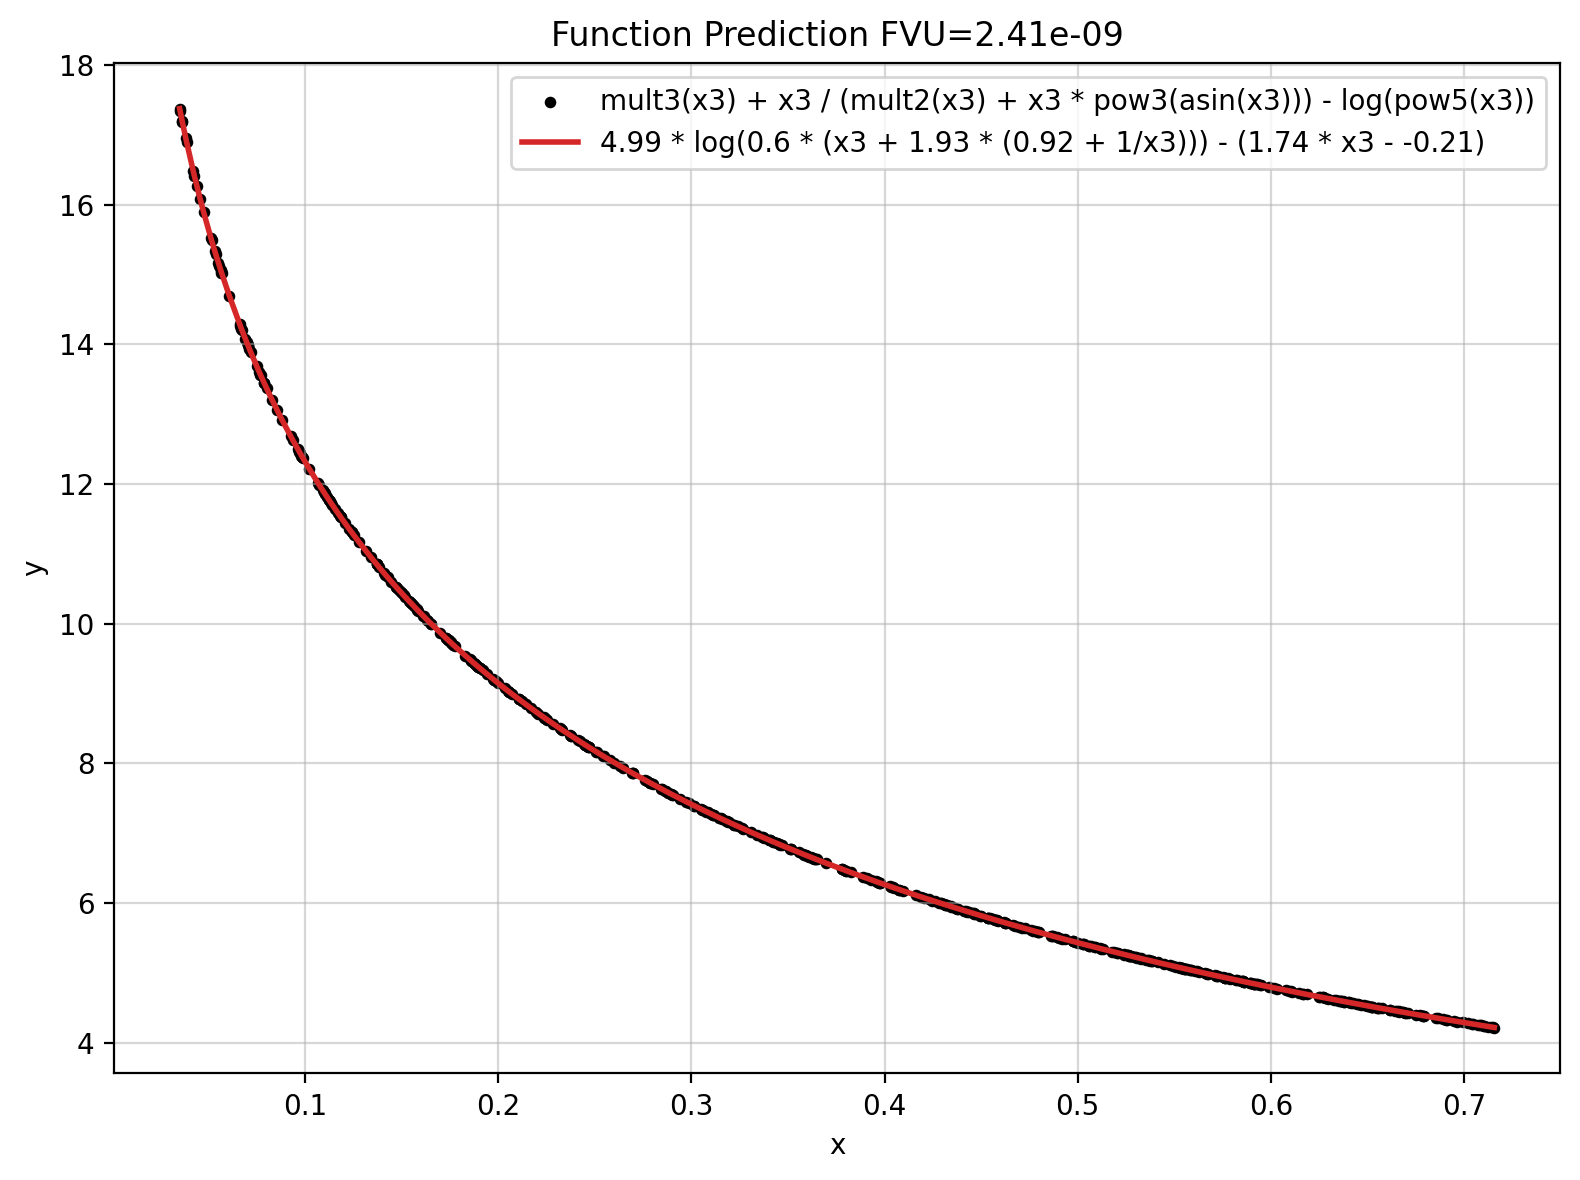

In [19]:
model = 'v21.0-60M'
test_set = 'pool_15_10'
n = 4096
idx = 19

valid_instances = np.where((results[model]['results'][test_set][n]['predicted_unique_variables'] == 1) & (results[model]['results'][test_set][n]['unique_variables'] == 1))[0]

instance = {k: results[model]['results'][test_set][n][k][valid_instances[idx]] for k in results[model]['results'][test_set][n].keys()}

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

x_nonzero = instance['x'][:, (instance['x'] != 0).all(axis=0)]
ax.scatter(x_nonzero, instance['y'], color='k', s=10, label=engine.prefix_to_infix(instance['expression']))

x_sorted_indices = np.argsort(x_nonzero[:, 0])
ax.plot(x_nonzero[x_sorted_indices], instance['y_pred'][x_sorted_indices], color='tab:red', linewidth=2, label=engine.prefix_to_infix(instance['predicted_expression_prefix']))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Function Prediction FVU={fvu(instance["y"], instance["y_pred"]):.2e}')
ax.legend()
ax.grid(alpha=0.5)
fig.tight_layout()

In [20]:
# n = 1
# model = 'PySR'
# test_set = 'pool_15_10'
# for i, (s, f) in enumerate(zip(
#     [results[model]['results'][test_set][n]['expression'][i] == results[model]['results'][test_set][n]['predicted_expression_prefix'][i] for i in range(len(results[model]['results'][test_set][n]['expression']))],
#     [results[model]['results'][test_set][n]['fvu_fit'][i] < 1e-5 for i in range(len(results[model]['results'][test_set][n]['expression']))])):

#     if s and not f:
#         print(s, f)
#         print(results[model]['results'][test_set][n]['expression'][i], results[model]['results'][test_set][n]['predicted_expression_prefix'][i])
#         print(results[model]['results'][test_set][n]['fvu_fit'][i])
#         print(results[model]['results'][test_set][n]['x'][i][0])
#         print()


In [21]:
# i = 0
# print(results['PySR']['results']['feynman'][256]['expression'][0])
# print(results['PySR']['results']['feynman'][256]['predicted_expression_prefix'][0])
# print(results['PySR']['results']['feynman'][256]['y_pred'][0][:10])
# print(results['PySR']['results']['feynman'][256]['y'][0][:10])
# print(results['PySR']['results']['feynman'][256]['x'][0][:10])

In [22]:
def getCDF(data, num_points=1000):
    data = np.array(data)
    data = data[np.isfinite(data)]
    if len(data) == 0:
        return np.array([]), np.array([])
    data = np.sort(data)
    x = np.linspace(np.min(data), np.max(data), num_points)
    y = np.searchsorted(data, x, side='right') / len(data)
    return x, y

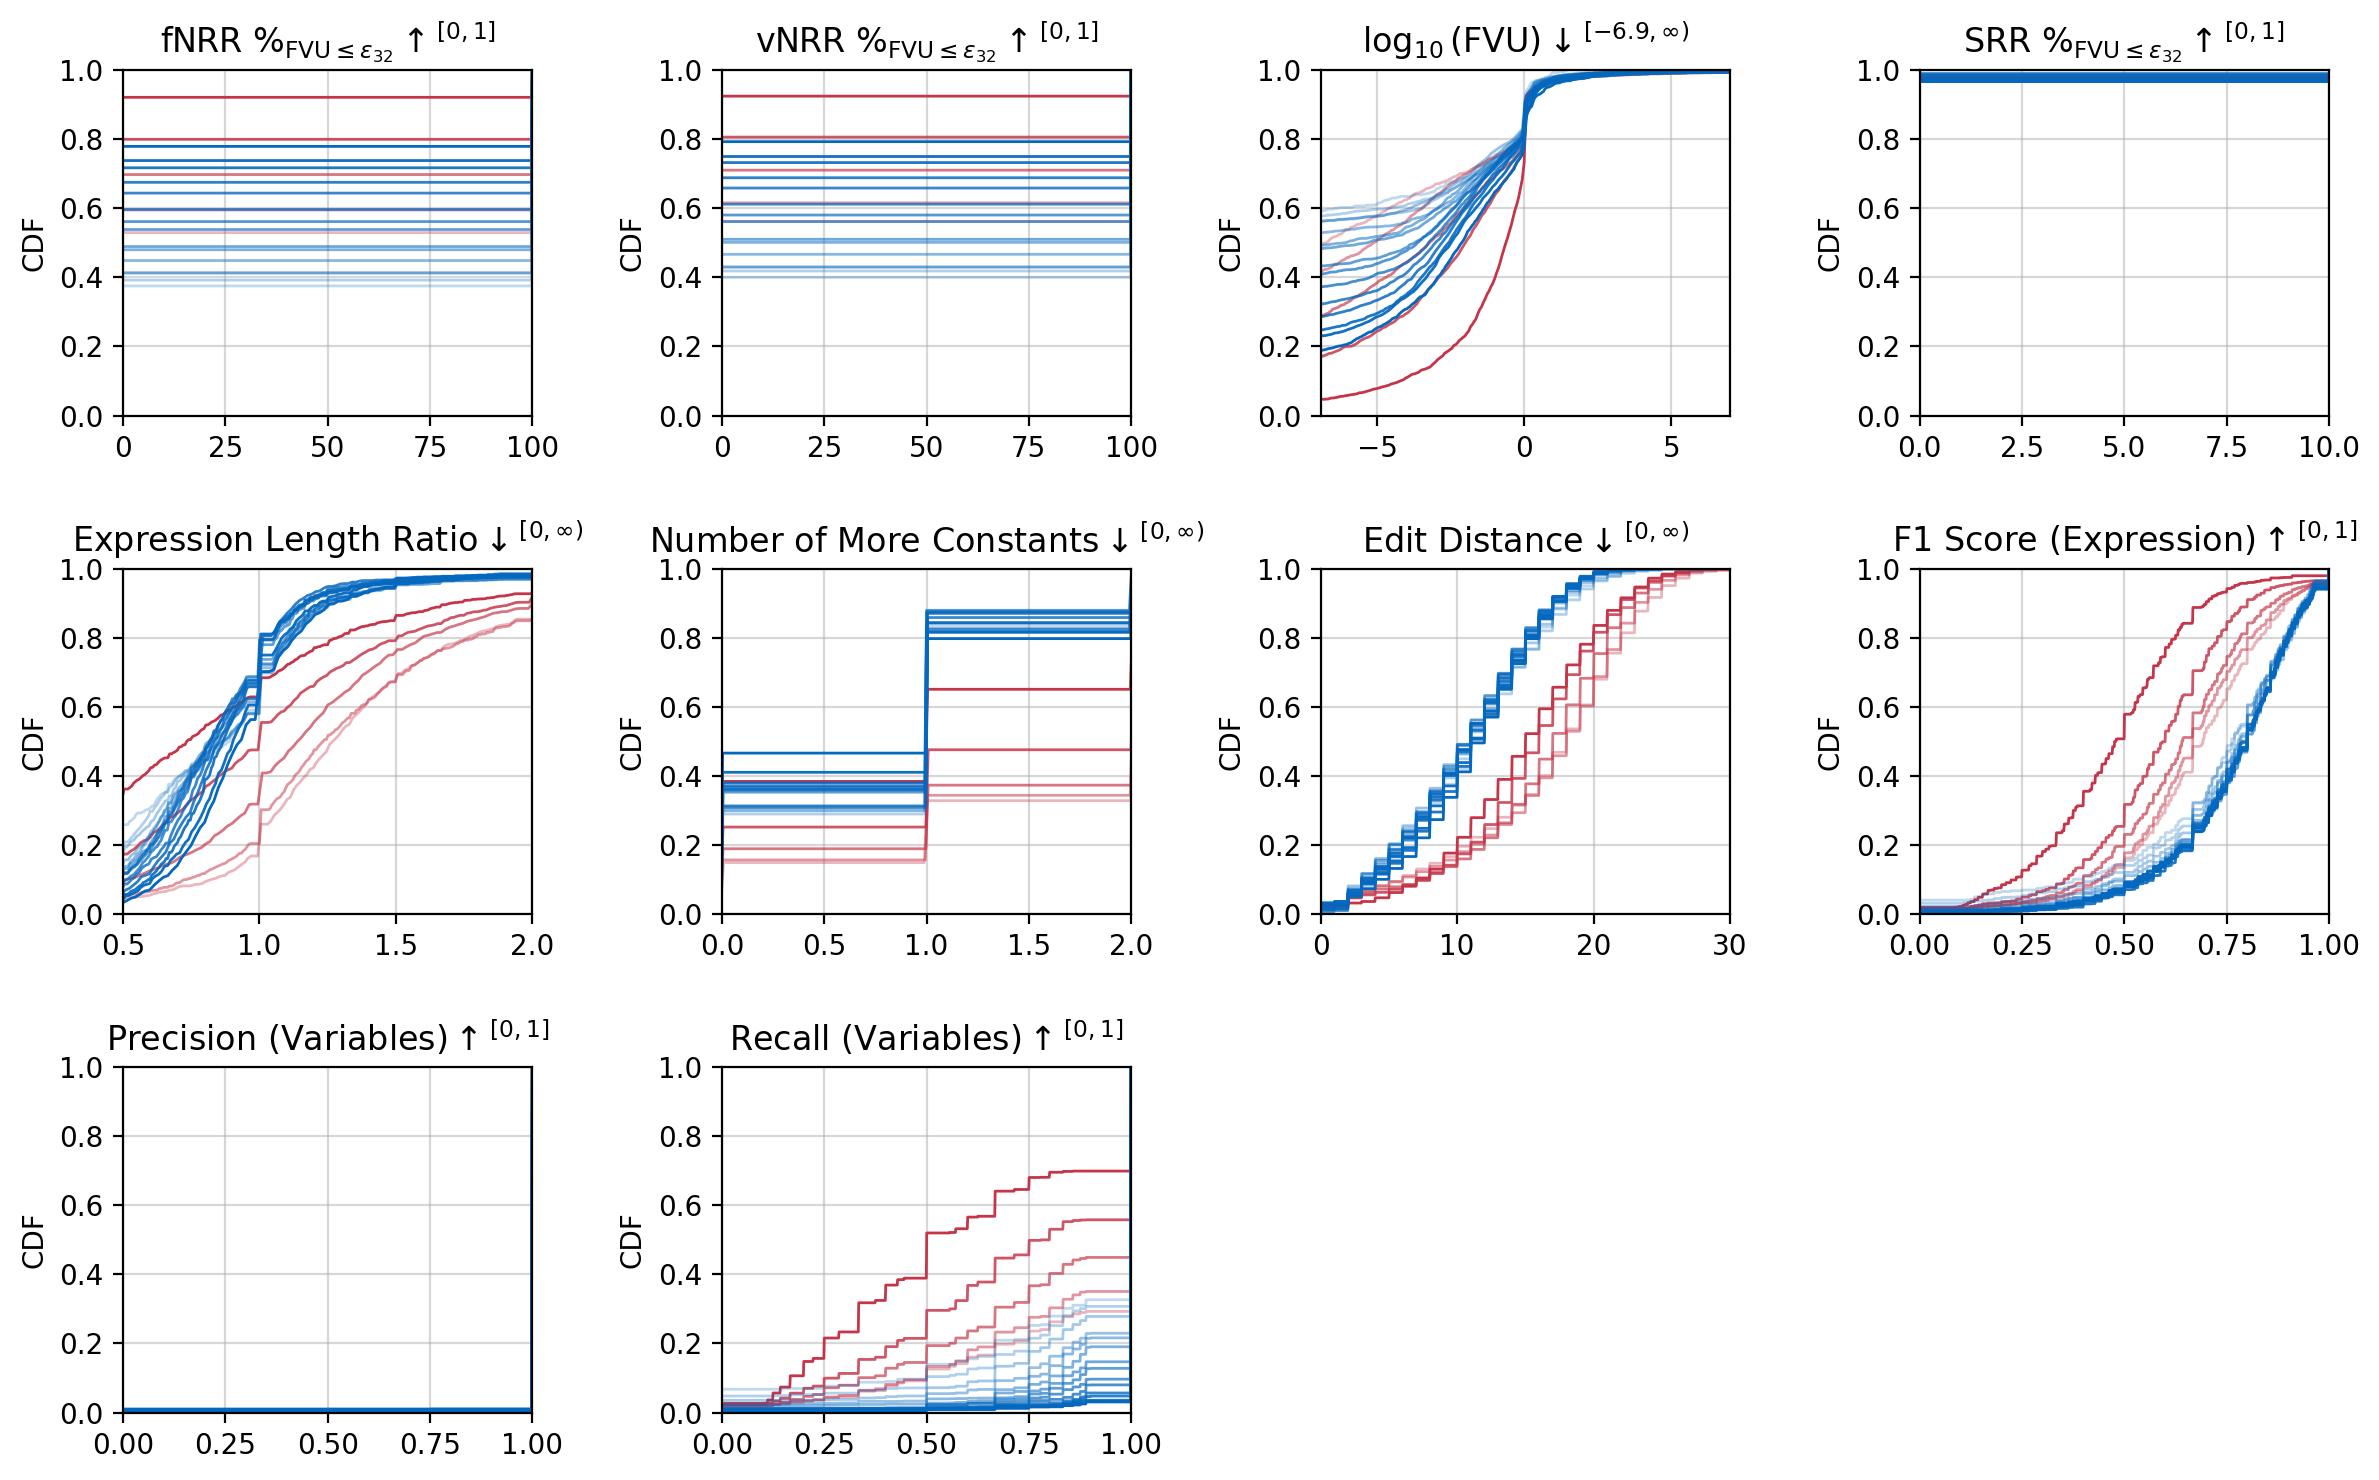

In [23]:
metric_pairs = [
    (
        'numeric_recovery_fit',
        f'fNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        100,
        (0, 100)
    ),
    (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        100,
        (0, 100)
    ),
    (
        'log10_fvu_val',
        f'$\\log_{{10}}(\mathrm{{FVU}}) {arrow_notation(objective=-1, lower=np.log10(np.finfo(np.float32).eps), upper=np.inf)}$',
        1,
        (np.log10(np.finfo(np.float32).eps), 7)
    ),
    (
        'symbolic_recovery',
        f'SRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        100,
        (0, 10)
    ),
    (
        'skeleton_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        1,
        (0.5, 2)
    ),
    (
        'n_constants_delta',
        f'$\mathrm{{Number\\ of\\ More\\ Constants}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        1,
        (0, 2)
    ),
    (
        'edit_distance',
        f'$\mathrm{{Edit\\ Distance}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        1,
        (0, 30)
    ),
    (
        'f1_score',
        f'$\mathrm{{F1\\ Score\\ (Expression)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        1,
        (0.0, 1)
    ),
    (
        'precision_unique_variables',
        f'$\mathrm{{Precision\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        1,
        (0.0, 1)
    ),
    (
        'recall_unique_variables',
        f'$\mathrm{{Recall\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        1,
        (0.0, 1)
    ),
]

models = [
    ('PySR', 'niterations', '#c53549'),
    # ('v21.0-8M', 'choices', '#05C7F2'),
    # ('v21.0-26M', 'choices', '#05AFF2'),
    ('v21.0-60M', 'choices', '#0468BF'),
    # ('v21.0-160M', 'choices', '#0339A6'),
    # ('v21.0-370M', 'choices', '#011640'),
]

COLS = 4
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(3 * COLS, 2.5 * ROWS), dpi=200)

# fig.text(
#     0.5,
#     0.5,
#     "Preliminary",
#     transform=fig.transFigure,
#     ha="center",
#     va="center",
#     fontsize=128,
#     color="tab:red",
#     alpha=0.12,
#     rotation=25,
#     weight="bold",
#     zorder=-0
# )

def get_alpha(i, n):
    return 0.2 + 0.8 * (1 - i / n)

for ax, (y_metric, y_label, y_factor, ylim) in zip(axes.flatten(), metric_pairs):
    ax: plt.Axes
    for model_name, scaling_param, color in models:
        for i, n in enumerate(results[model_name]['results']['pool_15_10'].keys()):
            y = results[model_name]['results']['pool_15_10'][n][y_metric]

            y_cdf_x, y_cdf_y = getCDF(y * y_factor)

            if ylim[0] is not None and ylim[1] is not None:
                ax.set_xlim(ylim)

            ax.plot(y_cdf_x, y_cdf_y, label=f"{model_name} ({n} {scaling_param})", color=color, alpha=get_alpha(i, len(results[model_name]['results']['pool_15_10'].keys())), linewidth=1)

    ax.set_ylabel('CDF')
    ax.set_title(y_label)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.5)


for ax in axes.flatten()[len(metric_pairs):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)


In [24]:
model = 'v21.0-26M'
test_set = 'pool_15_10'
# n = 1024

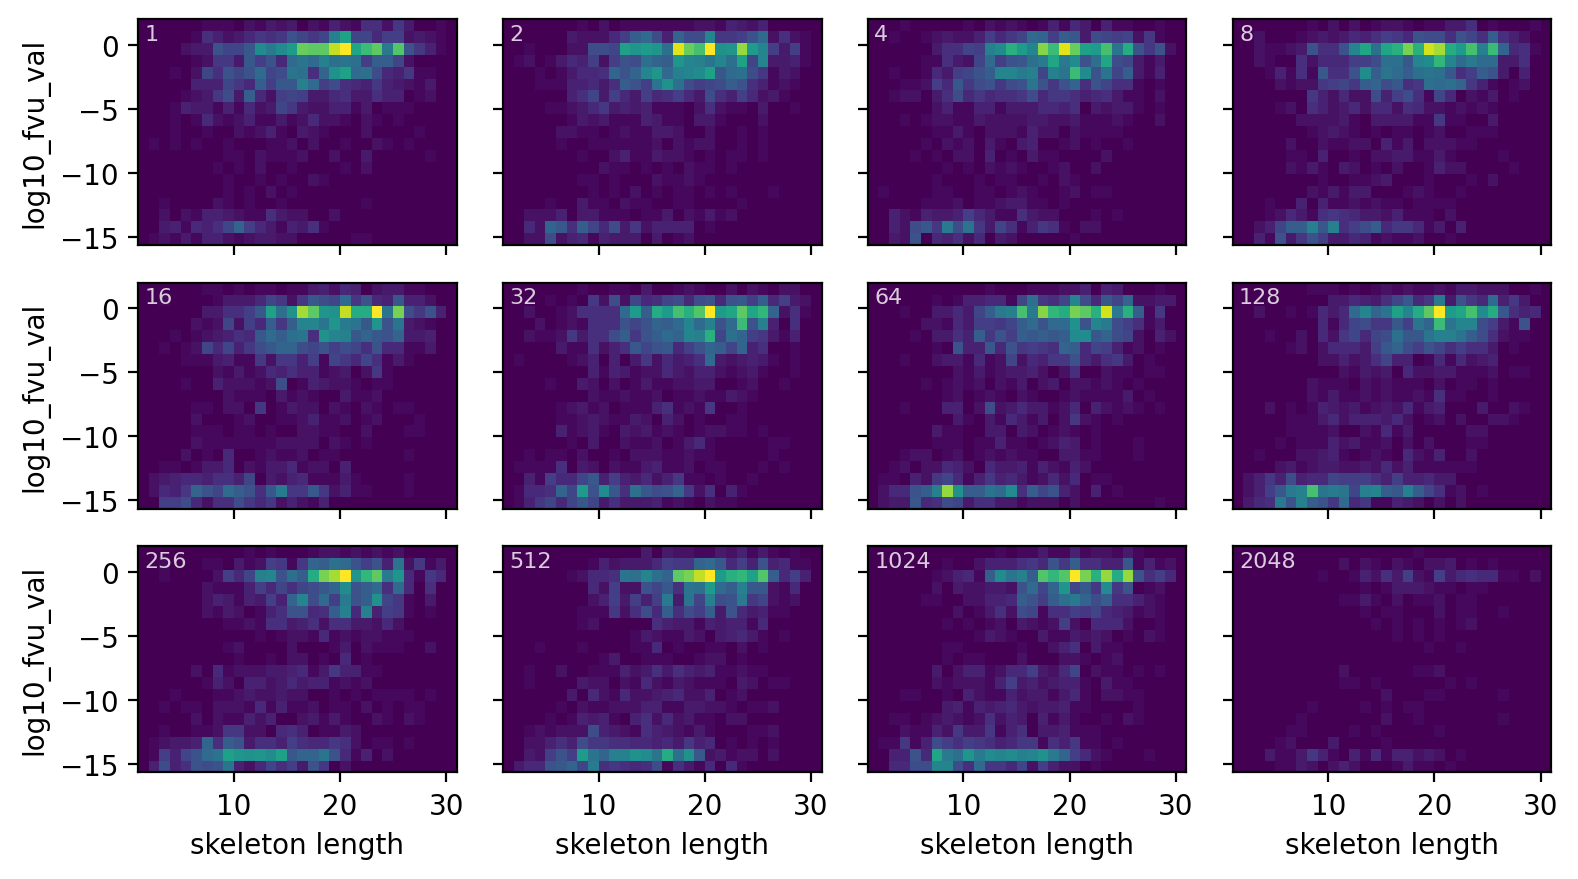

In [25]:
COLS = 4
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(2 * COLS, 1.5 * ROWS), dpi=200, sharex=True, sharey=True)

vmax = 0
for n, ax in zip(results[model]['results'][test_set].keys(), axes.flatten()):
    ax: plt.Axes
    x = results[model]['results'][test_set][n]['skeleton_length']
    y = results[model]['results'][test_set][n]['log10_fvu_val']

    # ax.hist2d(x, y, bins=(np.arange(1, 32), np.linspace(np.log10(np.finfo(np.float64).eps), 2, 32)));
    h, xedges, yedges = np.histogram2d(x, y, bins=(np.arange(1, 32), np.linspace(np.log10(np.finfo(np.float64).eps), 2, 32)))
    vmax = max(vmax, h.max())

for i, (n, ax) in enumerate(zip(results[model]['results'][test_set].keys(), axes.flatten())):
    ax: plt.Axes
    x = results[model]['results'][test_set][n]['skeleton_length']
    y = results[model]['results'][test_set][n]['log10_fvu_val']

    h, xedges, yedges, _ = ax.hist2d(x, y, bins=(np.arange(1, 32), np.linspace(np.log10(np.finfo(np.float64).eps), 2, 20)), vmax=vmax)

    

    ax.annotate(f"{n}", xy=(0.02, 0.98), xycoords='axes fraction', fontsize=8, color='w', ha='left', va='top', alpha=0.8)

    if i % COLS == 0:
        ax.set_ylabel('log10_fvu_val')
    if i // COLS == ROWS - 1:
        ax.set_xlabel('skeleton length')

fig.tight_layout(w_pad=1, h_pad=1)